In [2]:
import os
import sys
import warnings
import numpy as np
import matplotlib.pylab as plt
import astropy.units as u
import matplotlib.cm as cm
import matplotlib.gridspec as gridspec
import matplotlib.animation as animation
warnings.filterwarnings(action='ignore', category=RuntimeWarning)
import importlib

# Mid-Res Phoenix [Please modify this path to add your own spectral library]
sys.path.append('/Users/hritam/Documents/PhD/0. PhD_Papers_posters/Figures/Notebooks/Model')
import MidRes_PHOENIX as pho
from sage import sage_class



In [2]:
# cd /Users/hritam/Documents/PhD/2. SAGE/Sage_routine_dir

/Users/hritam/Documents/PhD/2. SAGE/Sage_routine_dir


In [63]:
pwd

'/Users/hritam/Documents/PhD/2. SAGE/Sage_routine_dir'

In [70]:
# SAGE
sys.path.append('/Users/hritam/Documents/PhD/2. SAGE/Sage_routine_dir')
!echo $PATH 
# from sage import sage_class


/Users/hritam/miniconda3/envs/spotify/bin:/Users/hritam/miniconda3/condabin:/Users/hritam/bin:/usr/local/bin:/opt/local/bin:/opt/local/sbin:/opt/homebrew/bin:/opt/homebrew/sbin:/usr/local/bin:/usr/bin:/bin:/usr/sbin:/sbin:/opt/X11/bin


ImportError: cannot import name 'sage_class' from 'sage' (/Users/hritam/Documents/PhD/2. SAGE/Sage_routine_dir/sage.py)

In [49]:
sage.

AttributeError: module 'sage' has no attribute 'star_class'

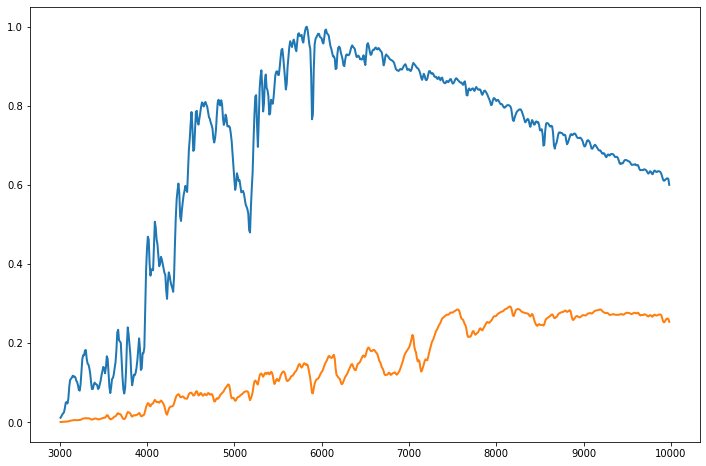

In [3]:
# Input spectral properties
Teff_star= 4500
Teff_spot= 3500
logg= 4.5
M_H= 0.0

wavein  = 3000.0                       # lower limit of wavelength in Angstrom
waveout = 10000.0                      # upper limit of wavelength in Angstrom

loc_library= '/Users/hritam/Documents/PhD/Phoenix_spectrum/SolarMetallacity'

def normalised_spec(Teff_star, Teff_spot, logg, wavein, waveout, loc, delta_wave=20):
    
    # High resolution spectrum 
    phoenix_wl_star, phoenix_fl_star= pho.PHOENIX_Spectrum_extractor(Teff= Teff_star, logg= logg, wavein= wavein, waveout= waveout, loc=loc_library)
    phoenix_wl_spot, phoenix_fl_spot= pho.PHOENIX_Spectrum_extractor(Teff= Teff_spot, logg= logg, wavein= wavein, waveout= waveout, loc=loc_library)
    # Low- Resolution spectrum 
    lowres_wl_star, lowres_fl_star= pho.convolving_spectrum(phoenix_wl_star, phoenix_fl_star, delta_wave) 
    lowres_wl_spot, lowres_fl_spot= pho.convolving_spectrum(phoenix_wl_spot, phoenix_fl_spot, delta_wave)

    # Normalisation
    wavelength= lowres_wl_spot
    flux_cold= lowres_fl_spot/ max(lowres_fl_star) 
    flux_hot= lowres_fl_star/ max(lowres_fl_star)
    
    return wavelength, flux_hot, flux_cold


wavelength, flux_hot, flux_cold= normalised_spec(Teff_star= Teff_star, Teff_spot= Teff_spot, logg= logg, wavein= wavein, waveout= waveout,
                                                       loc= loc_library, delta_wave=10)

plt.figure(figsize=(12,8))
plt.plot(wavelength, flux_hot, lw=2)
plt.plot(wavelength, flux_cold, lw=2)
plt.show()

In [4]:
# Limb-darkening parameters
u1= 0.0
u2= 0.0 

planet_pixel_size = 30

# Spot parameters
spotnumber = 1
spot_long= [-180]
spot_lat = [90]
spot_size = [4]
inclination= 90
ve = 0.0 #km sec^{-1}

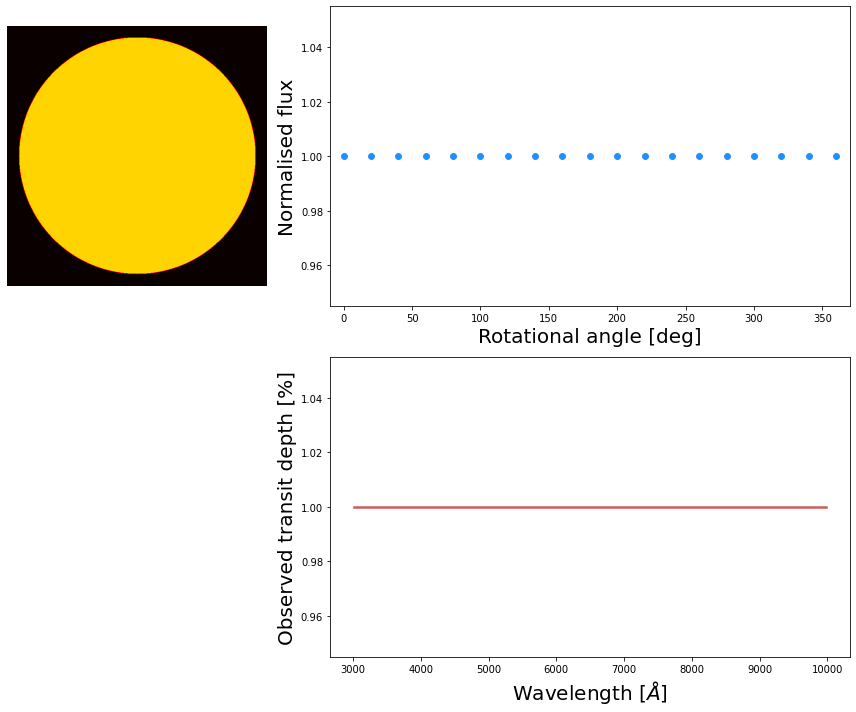

In [6]:
# plt.style.use('dark_background')
fig = plt.figure(figsize = (12,10))
gs = gridspec.GridSpec(2,2, width_ratios = [0.5, 1], height_ratios = [1, 1])     

ims = []


Delta_rotAngle= 20
NormFlux_arr=[]
phi_arr=[]
rotational_angle= np.arange(0, 360+Delta_rotAngle, Delta_rotAngle)

for phi in rotational_angle:
    
    # spot_long = spot_longitude
    # spot_long = spot_long + phi
    params=[phi,                                                   # Phase offset
            0.1,                                               # Radius-ratio 
            90.0,                                            # Inclination (deg)
            20.0 ,                                      # scaled semi-major axis 
            0.0,                                            # Period (days)
            0.0,                                             # Eccentricity (deg)
            0.0,                                                    # Omega (deg)
            u1,                                                  # U1
            u2,                                                  # U2
            2457584.329897,                           # Mid-transit point (days)
            0.0,                                      # cosine of angular distance
            0.0,                                      # Intensity profile 
            inclination]                                       # Stellar Inclination [90 deg is Face-on and 0 is edge-on] 

    # final_spectrum, stellar_spectrum, contamination_factor, star_map = sage(params, planet_pixel_size, 
    #                                                                   wavelength, flux_hot, flux_cold, 
    #                                                                   spot_lat, spot_long, spot_size, ve, spotnumber, 
    #                                                                   'single', 9200)
    T= sage_class(params, planet_pixel_size, 
                                                                      wavelength, flux_hot, flux_cold, 
                                                                      spot_lat, spot_long, spot_size, ve, spotnumber, 
                                                                      'single', 9200)
    
    final_spectrum, stellar_spectrum, contamination_factor, star_map = T.StarSpotSpec()


    lc_spec= np.sum(final_spectrum)
    lc_unspotted= np.sum(stellar_spectrum)
    NormFlux= lc_spec/ lc_unspotted
    
    phi_arr.append(phi)
    NormFlux_arr.append(NormFlux)

    ax1 = plt.subplot(gs[0,0])        
    img = ax1.imshow((star_map).T, cmap = cm.hot, interpolation = 'bilinear', origin = 'lower', vmin = 0.0, vmax = 1.0, animated = True)

    ax1.spines['top'].set_visible(False)
    ax1.spines['right'].set_visible(False)
    ax1.spines['bottom'].set_visible(False)
    ax1.spines['left'].set_visible(False)
    #ax1.set_title('$\lambda$= 3500 $\AA$', fontsize=14)

    plt.xticks([])
    plt.yticks([])


    ax2= plt.subplot(gs[0,1])
    img1 = ax2.scatter(phi_arr, NormFlux_arr, s = 35, color = 'DodgerBlue')
    ax2.set_xlim(-10, 370)
    ax2.set_xlabel('Rotational angle [deg]', fontsize=20)
    ax2.set_ylabel('Normalised flux', fontsize=20)

    
    ax3 = plt.subplot(gs[1, 1])
    img2, = ax3.plot(wavelength, contamination_factor, linewidth = 2.5, color = 'indianred')
    ax3.set_xlabel('Wavelength [$\AA$]', fontsize=20)
    ax3.set_ylabel('Observed transit depth [%]', fontsize=20)

    #ax4.set_ylabel('Stellar Contamination Factor ($\epsilon_{\lambda}$)')
    plt.tight_layout()

            
    ims.append([img, img1, img2])
        
ani = animation.ArtistAnimation(fig, ims, interval=300, blit=False, repeat = True, repeat_delay = 0)

# Writer = animation.writers['ffmpeg']
# Writer = Writer(fps=15, metadata=dict(artist='Me'), bitrate=1800)

ani.save(f'inc_{inclination}_experiment.gif', dpi= 300)
plt.show()

In [20]:
x
